In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [12]:
#load data
dataName="_mainExpAvDurEstimate_2025-03-27_15h13.32.171.csv"
#"_visualDurEstimate_2025-03-12_20h35.26.573.csv"

data = pd.read_csv("dataAvMain/"+dataName)
data[:4]
data['avgAVDeltaS'] = (data['deltaDurS'] + (data['recordedDurVisualTest'] - data['recordedDurVisualStandard'])) / 2
# Calculate deltaDurPercentVisual just as the difference between the test and standard visual durations over the standard visual duration
data['deltaDurPercentVisual'] = ((data['recordedDurVisualTest'] - data['recordedDurVisualStandard']) / data['recordedDurVisualStandard'] 
)

data['avgAVDeltaPercent'] = data[['delta_dur_percents', 'deltaDurPercentVisual']].mean(axis=1)
data

# Define columns for chosing test or standard
data['chose_test'] = (data['responses'] == data['order']).astype(int)
data['chose_standard'] = (data['responses'] != data['order']).astype(int)
try:
    data["riseDur"]>1
except:
    data["riseDur"]=1

data['standard_dur']=data['standardDur']
data[:3]

,Unnamed: 0,standardDur,riseDur,order,preDur,postDur,isiDur,trial_num,totalDur,delta_dur_percents,...,recordedOnsetVisualStandard,recordedOffsetVisualStandard,recordedDurVisualStandard,modalityPostCue,avgAVDeltaS,deltaDurPercentVisual,avgAVDeltaPercent,chose_test,chose_standard,standard_dur
0,0,0.4997,1.1993,2,0.4831,0.5414,0.5580,0,2.2071,-0.75,...,0.4112,1.0527,0.6415,A,-0.47065,-0.883087,-0.816543,0,1,0.4997
1,1,0.4997,0.0999,2,0.5414,0.4581,0.7163,1,2.3154,-0.80,...,0.4703,1.1118,0.6415,A,-0.49565,-0.922058,-0.861029,0,1,0.4997
2,2,0.4997,1.1993,1,0.6496,0.4498,0.6413,2,3.1149,0.75,...,2.1745,2.7660,0.5915,V,0.37465,0.633136,0.691568,1,0,0.4997


In [4]:
intensityVariable="avgAVDeltaPercent"

In [ ]:
from scipy.stats import norm
from scipy.optimize import minimize

def psychometric_function(intensities, lapse_rate, mu, sigma):
    # Cumulative distribution function with mean mu and standard deviation sigma
    cdf = norm.cdf(intensities, loc=mu, scale=sigma) 
    # take into account of lapse rate and return the probability of choosing test
    return lapse_rate * 0.5 + (1 - lapse_rate) * cdf 
# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params # Unpack parameters
    
    p = psychometric_function(delta_dur, lambda_, mu, sigma) # Compute probability of choosing test
    epsilon = 1e-9 # Add a small number to avoid log(0) when calculating the log-likelihood
    p = np.clip(p, epsilon, 1 - epsilon) # Clip p to avoid log(0) and log(1)
    # Compute the negative log-likelihood
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood


# Fit psychometric function
def fit_psychometric_function(levels,nResp, totalResp,init_guesses=[0,0,0]):
    # then fits the psychometric function
    # order is lambda mu sigma
    #initial_guess = [0, -0.2, 0.05]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.2), (-0.4, +0.4), (0.01, 1)]  # Reasonable bounds
    # fitting is done here
    result = minimize(
        negative_log_likelihood, x0=init_guesses, 
        args=(levels, nResp, totalResp),  # Pass the data and fixed parameters
        bounds=bounds,
        method='Nelder-Mead'
    )
    # returns the fitted parameters lambda, mu, sigma
    return result.x



In [105]:

def groupByChooseTest(x):
    grouped = x.groupby([intensityVariable, 'riseDur', 'standardDur','conflictDur']).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count'),
        num_of_chose_standard=('chose_standard', 'sum'),
    ).reset_index()
    grouped['p_choose_test'] = grouped['num_of_chose_test'] / grouped['total_responses']

    return grouped

grouped= groupByChooseTest(data)

In [108]:
grouped

,avgAVDeltaPercent,riseDur,standardDur,conflictDur,num_of_chose_test,total_responses,num_of_chose_standard,p_choose_test
0,-0.950000,0.0999,0.4997,-0.05,0,1,1,0.0
1,-0.950000,0.0999,0.4997,0.00,0,1,1,0.0
2,-0.861209,1.1993,0.4997,-0.05,0,1,1,0.0
3,-0.861191,0.0999,0.4997,0.05,0,1,1,0.0
4,-0.861185,0.0999,0.4997,0.05,1,1,0,1.0
...,...,...,...,...,...,...,...,...
352,0.737641,0.0999,0.4997,0.00,1,1,0,1.0
353,0.738178,0.0999,0.4997,0.00,1,1,0,1.0
354,0.738265,0.0999,0.4997,0.00,1,1,0,1.0
355,0.749938,1.1993,0.4997,0.00,1,1,0,1.0


In [200]:
def negative_log_likelihood(params, delta_dur, chose_tests, total_responses, conflicts, noise_levels):
    lambda_ = params[0]  # Lapse rate
    sigmaA = params[1]   # Standard deviation for audioNoise 0.1
    sigmaB = params[2]   # Standard deviation for audioNoise 1.2
    
    # Mean parameters for different conditions
    muAminus50 = params[3]  # Mean for audioNoise 0.1 and conflict -0.05
    muA0 = params[4]        # Mean for audioNoise 0.1 and conflict 0
    muAplus50 = params[5]   # Mean for audioNoise 0.1 and conflict 0.05
    muBminus50 = params[6]  # Mean for audioNoise 1.2 and conflict -0.05
    muB0 = params[7]        # Mean for audioNoise 1.2 and conflict 0
    muBplus50 = params[8]   # Mean for audioNoise 1.2 and conflict 0.05
    
    # Initialize negative log-likelihood
    nll = 0
    
    # Loop through each data point
    for i in range(len(delta_dur)):
        x = delta_dur[i]
        conflict = round(conflicts[i], 2)
        audio_noise = round(noise_levels[i], 2)
        total_response = total_responses[i]
        chose_test = chose_tests[i]
        
        # Select appropriate parameters based on condition
        if audio_noise == 0.1:
            sigma = sigmaA
            if conflict == -0.05:
                mu = muAminus50
            elif conflict == 0:
                mu = muA0
            elif conflict == 0.05:
                mu = muAplus50
            else:
                raise ValueError(f"Unknown conflict level: {conflict}")
        elif audio_noise == 1.2:
            sigma = sigmaB
            if conflict == -0.05:
                mu = muBminus50
            elif conflict == 0:
                mu = muB0
            elif conflict == 0.05:
                mu = muBplus50
            else:
                raise ValueError(f"Unknown conflict level: {conflict}")
        else:
            raise ValueError(f"Unknown audioNoise level: {audio_noise}")
        
        # Calculate the probability of choosing the test stimulus at level x
        p = psychometric_function(x, lambda_, mu, sigma)
        
        # Avoid numerical issues with log(0) or log(1)
        epsilon = 1e-9
        p = np.clip(p, epsilon, 1 - epsilon)
        
        # Add to the negative log-likelihood
        nll += -1 * (chose_test * np.log(p) + (total_response - chose_test) * np.log(1 - p))
    
    return nll

def fit_psychometric_function_M(grouped_data, intensity_variable='deltaDur', initGuesses=[0.05, 0.1, 0.1, -0.2, 0, 0.2, -0.2, 0, 0.2]):
    """
    Fit psychometric function to all conditions
    
    Parameters:
    -----------
    grouped_data : pandas DataFrame
        Grouped data with proportion of 'chose test' responses
    intensity_variable : str
        Column name for the intensity variable
        
    Returns:
    --------
    result : scipy.optimize.OptimizeResult
        Optimization result
    """
    intensities = grouped_data[intensity_variable].values
    chose_tests = grouped_data['num_of_chose_test'].values
    total_responses = grouped_data['total_responses'].values
    conflicts = grouped_data['conflictDur'].values
    noise_levels = grouped_data['riseDur'].values
    
    
    # Set bounds for parameters
    bounds = [(0, 0.2),      # lambda
              (0.02, 1),     # sigmaA
              (0.02, 1)]     # sigmaB
    bounds += [(-0.4, 0.4)] * 6  # All mu bounds

    # Minimize negative log-likelihood
    result = minimize(
        negative_log_likelihood,
        x0=initGuesses,
        args=(intensities, chose_tests, total_responses, conflicts, noise_levels),
        bounds=bounds,
        method='L-BFGS-B'  # Changed to L-BFGS-B which works well with bounds
    )
    
    return result







# Fit the psychometric function to the grouped data
#result = fit_psychometric_function(grouped, intensityVariable)


def fitMultipleStartingPoints(levels, nResp, totalResp,conflictLevels,noiseLevels, multipleInitGuesses):
    best_fit = None
    best_nll = float('inf')  # Initialize with infinity

    for i in range(len(multipleInitGuesses)):
        #try:
        fit = fit_psychometric_function_M(grouped, intensityVariable,initGuesses=multipleInitGuesses[i])
        nll = negative_log_likelihood(fit.x, levels, nResp, totalResp,conflictLevels, noiseLevels)

        if nll < best_nll:
            best_nll = nll
            best_fit = fit
        # except Exception as e:
        #     print(f"Error fitting with initial guesses {multipleInitGuesses[i]}: {e}")

    return best_fit



In [201]:
multipleInitGuesses = []
# 100 random multiple starts
nStarts = 3
initLambdas = np.linspace(0, 0.2, nStarts)  # Different initial guesses for lambda
initSigmaA = np.linspace(0.05, 1, nStarts)  # Different initial guesses for sigma
initSigmaB = np.linspace(0.05, 1, nStarts)  # Different initial guesses for sigma
initMuA1 = np.linspace(-0.4, 0.4, nStarts)  # Different initial guesses for mu
initMuA2 = np.linspace(-0.4, 0.4, nStarts)  # Different initial guesses for mu
initMuA3 = np.linspace(-0.4, 0.4, nStarts)  # Different initial guesses for mu
initMuB1 = np.linspace(-0.4, 0.4, nStarts)  # Different initial guesses for mu
initMuB2 = np.linspace(-0.4, 0.4, nStarts)  # Different initial guesses for mu
initMuB3 = np.linspace(-0.4, 0.4, nStarts)  # Different initial guesses for mu
for i in range(nStarts):
    multipleInitGuesses.append([initLambdas[i], initSigmaA[i], initSigmaB[i], initMuA1[i], initMuA2[i], initMuA3[i], initMuB1[i], initMuB2[i], initMuB3[i]])

    

multipleInitGuesses[0]



[0.0, 0.05, 0.05, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4]

In [202]:
# Fit the psychometric function to the grouped data

levels = grouped[intensityVariable].values
nResp = grouped['num_of_chose_test'].values
totalResp = grouped['total_responses'].values
conflictLevels = grouped['conflictDur'].values
noiseLevels = grouped['riseDur'].values
fixedLapse = None
fixedSigma = None
best_fit = fitMultipleStartingPoints(levels, nResp, totalResp, conflictLevels, noiseLevels,multipleInitGuesses)

Trying initial guesses: [0.0, 0.05, 0.05, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4]
Fit result:   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 171.3513124325737
        x: [ 9.016e-02  4.291e-01  6.751e-01  1.182e-01  5.914e-02
             1.138e-01  8.054e-02  1.176e-01  1.788e-01]
      nit: 33
      jac: [-2.558e-05 -4.263e-05  1.705e-05 -6.253e-05  7.105e-05
             2.842e-06 -7.958e-05  7.390e-05 -1.990e-05]
     nfev: 480
     njev: 48
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
Trying initial guesses: [0.1, 0.525, 0.525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Fit result:   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 171.35131253241553
        x: [ 9.016e-02  4.291e-01  6.752e-01  1.182e-01  5.911e-02
             1.138e-01  8.053e-02  1.176e-01  1.788e-01]
      nit: 15
      jac: [ 1.762e-04 -1.410e-03  2.052e-03 -2.285e-03 -1.592e-03
             1.120e-03 -5.173e-04 -1.

9

Fitting Results:
----------------------------------------
Lambda: 0.0902
SigmaA (0.1): 0.4291
SigmaB (1.2): 0.6752
MuA-50: 0.1182
MuA0: 0.0591
MuA+50: 0.1138
MuB-50: 0.0805
MuB0: 0.1176
MuB+50: 0.1788
----------------------------------------
Negative Log-Likelihood: 171.3513
Success: True
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


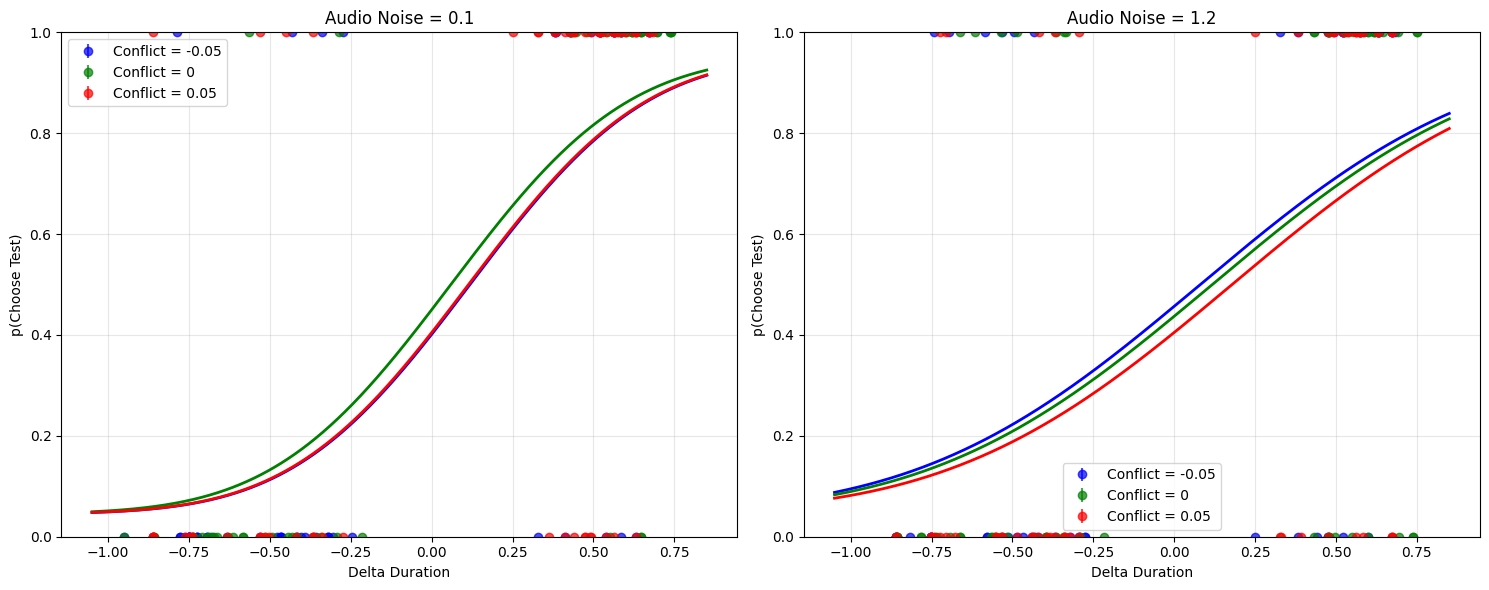

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.special import expit  # For logistic function
import seaborn as sns

# Define the psychometric function (using a cumulative Gaussian)
def psychometric_function(x, lambda_, mu, sigma):
    """
    Psychometric function with lapse rate
    
    Parameters:
    -----------
    x : array-like
        Stimulus intensity (delta duration)
    lambda_ : float
        Lapse rate (0-1)
    mu : float
        Point of subjective equality (PSE)
    sigma : float
        Standard deviation (precision)
        
    Returns:
    --------
    p : array-like
        Probability of choosing test stimulus
    """
    # Apply lapse rate: p = lambda/2 + (1-lambda) * Φ((x-mu)/sigma)
    p = lambda_/2 + (1-lambda_) * norm.cdf((x - mu) / sigma)
    return p

def group_by_choose_test(data, intensity_variable='deltaDur'):
    """
    Group data by relevant variables and calculate proportion of 'chose test' responses
    
    Parameters:
    -----------
    data : pandas DataFrame
        Raw experimental data
    intensity_variable : str
        Column name for the intensity variable
        
    Returns:
    --------
    grouped : pandas DataFrame
        Grouped data with proportion of 'chose test' responses
    """
    grouped = data.groupby([intensity_variable, 'riseDur', 'standardDur', 'conflictDur']).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count'),
        num_of_chose_standard=('chose_standard', 'sum'),
    ).reset_index()
    
    grouped['p_choose_test'] = grouped['num_of_chose_test'] / grouped['total_responses']
    return grouped

def negative_log_likelihood(params, delta_dur, chose_tests, total_responses, conflicts, noise_levels):
    """
    Calculate negative log-likelihood for psychometric function across multiple conditions
    
    Parameters:
    -----------
    params : array-like
        Model parameters [lambda, sigmaA, sigmaB, muA-50, muA0, muA+50, muB-50, muB0, muB+50]
    delta_dur : array-like
        Stimulus intensities
    chose_tests : array-like
        Number of 'chose test' responses for each condition
    total_responses : array-like
        Total number of responses for each condition
    conflicts : array-like
        Conflict conditions
    noise_levels : array-like
        Noise levels
        
    Returns:
    --------
    nll : float
        Negative log-likelihood
    """
    lambda_ = params[0]  # Lapse rate
    sigmaA = params[1]   # Standard deviation for audioNoise 0.1
    sigmaB = params[2]   # Standard deviation for audioNoise 1.2
    
    # Mean parameters for different conditions
    muAminus50 = params[3]  # Mean for audioNoise 0.1 and conflict -0.05
    muA0 = params[4]        # Mean for audioNoise 0.1 and conflict 0
    muAplus50 = params[5]   # Mean for audioNoise 0.1 and conflict 0.05
    muBminus50 = params[6]  # Mean for audioNoise 1.2 and conflict -0.05
    muB0 = params[7]        # Mean for audioNoise 1.2 and conflict 0
    muBplus50 = params[8]   # Mean for audioNoise 1.2 and conflict 0.05
    
    # Initialize negative log-likelihood
    nll = 0
    
    # Loop through each data point
    for i in range(len(delta_dur)):
        x = delta_dur[i]
        conflict = round(conflicts[i], 2)
        audio_noise = round(noise_levels[i], 2)
        total_response = total_responses[i]
        chose_test = chose_tests[i]
        
        # Select appropriate parameters based on condition
        if audio_noise == 0.1:
            sigma = sigmaA
            if conflict == -0.05:
                mu = muAminus50
            elif conflict == 0:
                mu = muA0
            elif conflict == 0.05:
                mu = muAplus50
            else:
                raise ValueError(f"Unknown conflict level: {conflict}")
        elif audio_noise == 1.2:
            sigma = sigmaB
            if conflict == -0.05:
                mu = muBminus50
            elif conflict == 0:
                mu = muB0
            elif conflict == 0.05:
                mu = muBplus50
            else:
                raise ValueError(f"Unknown conflict level: {conflict}")
        else:
            raise ValueError(f"Unknown audioNoise level: {audio_noise}")
        
        # Calculate the probability of choosing the test stimulus
        p = psychometric_function(x, lambda_, mu, sigma)
        
        # Avoid numerical issues with log(0) or log(1)
        epsilon = 1e-9
        p = np.clip(p, epsilon, 1 - epsilon)
        
        # Add to the negative log-likelihood
        nll += -1 * (chose_test * np.log(p) + (total_response - chose_test) * np.log(1 - p))
    
    return nll

def fit_psychometric_function(grouped_data, intensity_variable='deltaDur'):
    """
    Fit psychometric function to all conditions
    
    Parameters:
    -----------
    grouped_data : pandas DataFrame
        Grouped data with proportion of 'chose test' responses
    intensity_variable : str
        Column name for the intensity variable
        
    Returns:
    --------
    result : scipy.optimize.OptimizeResult
        Optimization result
    """
    intensities = grouped_data[intensity_variable].values
    chose_tests = grouped_data['num_of_chose_test'].values
    total_responses = grouped_data['total_responses'].values
    conflicts = grouped_data['conflictDur'].values
    noise_levels = grouped_data['riseDur'].values
    
    # Initial guesses: lambda, sigmaA, sigmaB, muA-50, muA0, muA+50, muB-50, muB0, muB+50
    init_guess = [0.03, 0.1, 0.1] + [0.0] * 6
    
    # Set bounds for parameters
    bounds = [(0, 0.2),      # lambda
              (0.02, 1),     # sigmaA
              (0.02, 1)]     # sigmaB
    bounds += [(-0.4, 0.4)] * 6  # All mu bounds
    
    # Minimize negative log-likelihood
    result = minimize(
        negative_log_likelihood,
        x0=init_guess,
        args=(intensities, chose_tests, total_responses, conflicts, noise_levels),
        bounds=bounds,
        method='L-BFGS-B'  # Changed to L-BFGS-B which works well with bounds
    )
    
    return result

def plot_psychometric_curves(result, grouped_data, intensity_variable='deltaDur'):
    """
    Plot psychometric curves for all conditions
    
    Parameters:
    -----------
    result : scipy.optimize.OptimizeResult
        Optimization result
    grouped_data : pandas DataFrame
        Grouped data with proportion of 'chose test' responses
    intensity_variable : str
        Column name for the intensity variable
    """
    params = result.x
    lambda_ = params[0]
    sigmaA = params[1]
    sigmaB = params[2]
    
    # Extract parameters for different conditions
    mu_params = {
        (0.1, -0.05): params[3],
        (0.1, 0): params[4],
        (0.1, 0.05): params[5],
        (1.2, -0.05): params[6],
        (1.2, 0): params[7],
        (1.2, 0.05): params[8]
    }
    
    # Set up the figure
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Colors for different conflict conditions
    colors = {-0.05: 'blue', 0: 'green', 0.05: 'red'}
    
    # Noise levels
    noise_levels = [0.1, 1.2]
    
    # Create smooth x values for plotting curves
    x_smooth = np.linspace(
        grouped_data[intensity_variable].min() - 0.1,
        grouped_data[intensity_variable].max() + 0.1,
        1000
    )
    
    for i, noise in enumerate(noise_levels):
        ax = axes[i]
        ax.set_title(f'Audio Noise = {noise}')
        ax.set_xlabel('Delta Duration')
        ax.set_ylabel('p(Choose Test)')
        
        # Plot data points and fitted curves for each conflict condition
        for conflict in [-0.05, 0, 0.05]:
            # Get data for this condition
            mask = (grouped_data['riseDur'].round(2) == noise) & (grouped_data['conflictDur'].round(2) == conflict)
            subset = grouped_data[mask]
            
            # Plot data points
            ax.errorbar(
                subset[intensity_variable],
                subset['p_choose_test'],
                yerr=np.sqrt(subset['p_choose_test'] * (1 - subset['p_choose_test']) / subset['total_responses']),
                fmt='o',
                color=colors[conflict],
                alpha=0.7,
                label=f'Conflict = {conflict}'
            )
            
            # Get parameters for this condition
            mu = mu_params[(noise, conflict)]
            sigma = sigmaA if noise == 0.1 else sigmaB
            
            # Plot fitted curve
            y_smooth = psychometric_function(x_smooth, lambda_, mu, sigma)
            ax.plot(x_smooth, y_smooth, color=colors[conflict], lw=2)
        
        ax.grid(alpha=0.3)
        ax.legend()
        ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def main(data, intensity_variable='avgAVDeltaPercent'):
    """
    Main function to run the analysis
    
    Parameters:
    -----------
    data : pandas DataFrame
        Raw experimental data
    intensity_variable : str
        Column name for the intensity variable
        
    Returns:
    --------
    result : scipy.optimize.OptimizeResult
        Optimization result
    grouped : pandas DataFrame
        Grouped data with proportion of 'chose test' responses
    """
    # Group data
    grouped = group_by_choose_test(data, intensity_variable)
    
    # Fit psychometric function
    result = fit_psychometric_function(grouped, intensity_variable)
    
    # Print fitting results
    params = result.x
    param_names = ['Lambda', 'SigmaA (0.1)', 'SigmaB (1.2)', 
                  'MuA-50', 'MuA0', 'MuA+50', 
                  'MuB-50', 'MuB0', 'MuB+50']
    
    print("Fitting Results:")
    print("-" * 40)
    for name, value in zip(param_names, params):
        print(f"{name}: {value:.4f}")
    print("-" * 40)
    print(f"Negative Log-Likelihood: {result.fun:.4f}")
    print(f"Success: {result.success}")
    print(f"Message: {result.message}")
    
    # Plot psychometric curves
    fig = plot_psychometric_curves(result, grouped, intensity_variable)
    
    return result, grouped, fig

# Example usage:
result, grouped_data, fig = main(data, 'avgAVDeltaPercent')

In [125]:
pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


Fitting with multiple starting points...


Fitting with multiple starting points:   0%|          | 0/135 [00:00<?, ?it/s]


Best Fitting Results:
----------------------------------------
Lambda (lapse rate): 0.0902
Sigma A (noise=0.1): 0.4291
Sigma B (noise=1.2): 0.6751
Mu A -0.05 (noise=0.1, conflict=-0.05): 0.1182
Mu A 0 (noise=0.1, conflict=0): 0.0591
Mu A +0.05 (noise=0.1, conflict=0.05): 0.1138
Mu B -0.05 (noise=1.2, conflict=-0.05): 0.0805
Mu B 0 (noise=1.2, conflict=0): 0.1176
Mu B +0.05 (noise=1.2, conflict=0.05): 0.1788
Negative Log-Likelihood: 171.3513
----------------------------------------
Success: True
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


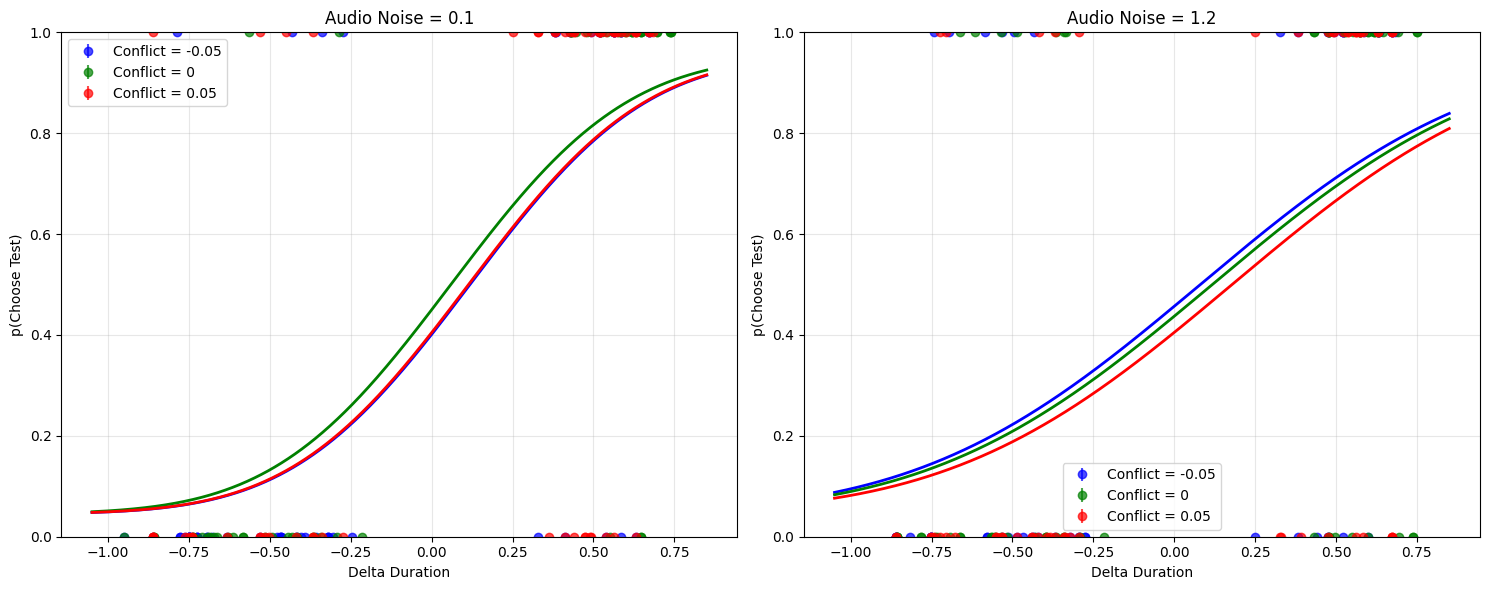

Fitting full model: All parameters free...


Fitting with multiple starting points:   0%|          | 0/40 [00:00<?, ?it/s]

Fitting fixed_lapse model: Fixed lapse rate (λ=0.05)...


Fitting with multiple starting points:   0%|          | 0/20 [00:00<?, ?it/s]

Fitting equal_sigma model: Equal σ for both noise conditions...
Fitting fixed_lapse_equal_sigma model: Fixed λ and equal σ...

Model Comparison:
--------------------------------------------------------------------------------
Model                     NLL        k     AIC        BIC       
--------------------------------------------------------------------------------
Fixed lapse rate (λ=0.05) 171.40     8     358.79     389.91    
All parameters free       171.35     9     360.70     395.70    
Fixed λ and equal σ       173.67     7     361.34     388.56    
Equal σ for both noise conditions 173.66     8     363.32     394.43    


In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.special import expit  # For logistic function
import seaborn as sns
import itertools
from tqdm.notebook import tqdm  # For progress bar in Jupyter

# Define the psychometric function (using a cumulative Gaussian)
def psychometric_function(x, lambda_, mu, sigma):
    """
    Psychometric function with lapse rate
    
    Parameters:
    -----------
    x : array-like
        Stimulus intensity (delta duration)
    lambda_ : float
        Lapse rate (0-1)
    mu : float
        Point of subjective equality (PSE)
    sigma : float
        Standard deviation (precision)
        
    Returns:
    --------
    p : array-like
        Probability of choosing test stimulus
    """
    # Apply lapse rate: p = lambda/2 + (1-lambda) * Φ((x-mu)/sigma)
    p = lambda_/2 + (1-lambda_) * norm.cdf((x - mu) / sigma)
    return p

def group_by_choose_test(data, intensity_variable='deltaDur'):
    """
    Group data by relevant variables and calculate proportion of 'chose test' responses
    
    Parameters:
    -----------
    data : pandas DataFrame
        Raw experimental data
    intensity_variable : str
        Column name for the intensity variable
        
    Returns:
    --------
    grouped : pandas DataFrame
        Grouped data with proportion of 'chose test' responses
    """
    grouped = data.groupby([intensity_variable, 'riseDur', 'standardDur', 'conflictDur']).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count'),
        num_of_chose_standard=('chose_standard', 'sum'),
    ).reset_index()
    
    grouped['p_choose_test'] = grouped['num_of_chose_test'] / grouped['total_responses']
    return grouped

def negative_log_likelihood(params, delta_dur, chose_tests, total_responses, conflicts, noise_levels, 
                           fixed_lapse=None, fixed_sigma_a=None, fixed_sigma_b=None):
    """
    Calculate negative log-likelihood for psychometric function across multiple conditions
    
    Parameters:
    -----------
    params : array-like
        Model parameters - contents depend on what's fixed
    delta_dur : array-like
        Stimulus intensities
    chose_tests : array-like
        Number of 'chose test' responses for each condition
    total_responses : array-like
        Total number of responses for each condition
    conflicts : array-like
        Conflict conditions
    noise_levels : array-like
        Noise levels
    fixed_lapse : float or None
        Fixed value for lapse rate (if None, it's a free parameter)
    fixed_sigma_a : float or None
        Fixed value for sigma A (if None, it's a free parameter)
    fixed_sigma_b : float or None
        Fixed value for sigma B (if None, it's a free parameter)
        
    Returns:
    --------
    nll : float
        Negative log-likelihood
    """
    # Unpack parameters - handle the case where some parameters are fixed
    param_index = 0
    
    if fixed_lapse is None:
        lambda_ = params[param_index]
        param_index += 1
    else:
        lambda_ = fixed_lapse
        
    if fixed_sigma_a is None:
        sigmaA = params[param_index]
        param_index += 1
    else:
        sigmaA = fixed_sigma_a
        
    if fixed_sigma_b is None:
        sigmaB = params[param_index]
        param_index += 1
    else:
        sigmaB = fixed_sigma_b
    
    # Remaining parameters are mu values
    muAminus50 = params[param_index]
    muA0 = params[param_index + 1]
    muAplus50 = params[param_index + 2]
    muBminus50 = params[param_index + 3]
    muB0 = params[param_index + 4]
    muBplus50 = params[param_index + 5]
    
    # Initialize negative log-likelihood
    nll = 0
    
    # Loop through each data point
    for i in range(len(delta_dur)):
        x = delta_dur[i]
        conflict = round(conflicts[i], 2)
        audio_noise = round(noise_levels[i], 2)
        total_response = total_responses[i]
        chose_test = chose_tests[i]
        
        # Select appropriate parameters based on condition
        if audio_noise == 0.1:
            sigma = sigmaA
            if conflict == -0.05:
                mu = muAminus50
            elif conflict == 0:
                mu = muA0
            elif conflict == 0.05:
                mu = muAplus50
            else:
                raise ValueError(f"Unknown conflict level: {conflict}")
        elif audio_noise == 1.2:
            sigma = sigmaB
            if conflict == -0.05:
                mu = muBminus50
            elif conflict == 0:
                mu = muB0
            elif conflict == 0.05:
                mu = muBplus50
            else:
                raise ValueError(f"Unknown conflict level: {conflict}")
        else:
            raise ValueError(f"Unknown audioNoise level: {audio_noise}")
        
        # Calculate the probability of choosing the test stimulus
        p = psychometric_function(x, lambda_, mu, sigma)
        
        # Avoid numerical issues with log(0) or log(1)
        epsilon = 1e-9
        p = np.clip(p, epsilon, 1 - epsilon)
        
        # Add to the negative log-likelihood
        nll += -1 * (chose_test * np.log(p) + (total_response - chose_test) * np.log(1 - p))
    
    return nll

def fit_psychometric_function(grouped_data, intensity_variable='deltaDur', 
                            init_guess=None, fixed_lapse=None, fixed_sigma_a=None, fixed_sigma_b=None):
    """
    Fit psychometric function to all conditions
    
    Parameters:
    -----------
    grouped_data : pandas DataFrame
        Grouped data with proportion of 'chose test' responses
    intensity_variable : str
        Column name for the intensity variable
    init_guess : array-like or None
        Initial parameter values (if None, default values are used)
    fixed_lapse : float or None
        Fixed value for lapse rate (if None, it's a free parameter)
    fixed_sigma_a : float or None
        Fixed value for sigma A (if None, it's a free parameter)
    fixed_sigma_b : float or None
        Fixed value for sigma B (if None, it's a free parameter)
        
    Returns:
    --------
    result : scipy.optimize.OptimizeResult
        Optimization result
    """
    intensities = grouped_data[intensity_variable].values
    chose_tests = grouped_data['num_of_chose_test'].values
    total_responses = grouped_data['total_responses'].values
    conflicts = grouped_data['conflictDur'].values
    noise_levels = grouped_data['riseDur'].values
    
    # Determine which parameters are free vs fixed
    free_params = []
    bounds = []
    
    # Default initial guesses if none provided
    if init_guess is None:
        # Standard initial values
        if fixed_lapse is None:
            free_params.append(0.03)  # lambda
            bounds.append((0, 0.2))
            
        if fixed_sigma_a is None:
            free_params.append(0.1)   # sigmaA
            bounds.append((0.02, 1))
            
        if fixed_sigma_b is None:
            free_params.append(0.1)   # sigmaB
            bounds.append((0.02, 1))
            
        # Add mu parameters (never fixed)
        free_params.extend([0.0] * 6)  # All mu values start at 0
        bounds.extend([(-0.4, 0.4)] * 6)  # All mu bounds
    else:
        # Use provided initial guesses
        param_index = 0
        
        if fixed_lapse is None:
            free_params.append(init_guess[param_index])
            bounds.append((0, 0.2))
            param_index += 1
            
        if fixed_sigma_a is None:
            free_params.append(init_guess[param_index])
            bounds.append((0.02, 1))
            param_index += 1
            
        if fixed_sigma_b is None:
            free_params.append(init_guess[param_index])
            bounds.append((0.02, 1))
            param_index += 1
            
        # Add mu parameters
        remaining_params = len(init_guess) - param_index
        if remaining_params < 6:
            raise ValueError("Not enough initial guesses provided for mu parameters")
            
        free_params.extend(init_guess[param_index:param_index+6])
        bounds.extend([(-0.4, 0.4)] * 6)
    
    # Minimize negative log-likelihood
    result = minimize(
        negative_log_likelihood,
        x0=free_params,
        args=(intensities, chose_tests, total_responses, conflicts, noise_levels, 
             fixed_lapse, fixed_sigma_a, fixed_sigma_b),
        bounds=bounds,
        method='L-BFGS-B'  # Changed to L-BFGS-B which works well with bounds
    )
    
    return result

def fit_multiple_starting_points(grouped_data, intensity_variable='deltaDur', 
                               n_lambda=3, n_sigma=3, n_mu=3, 
                               fixed_lapse=None, fixed_sigma_a=None, fixed_sigma_b=None,
                               show_progress=True):
    """
    Fit psychometric function using multiple starting points to avoid local minima
    
    Parameters:
    -----------
    grouped_data : pandas DataFrame
        Grouped data with proportion of 'chose test' responses
    intensity_variable : str
        Column name for the intensity variable
    n_lambda : int
        Number of starting points for lambda parameter
    n_sigma : int
        Number of starting points for sigma parameters
    n_mu : int
        Number of starting points for mu parameters
    fixed_lapse : float or None
        Fixed value for lapse rate (if None, it's a free parameter)
    fixed_sigma_a : float or None
        Fixed value for sigma A (if None, it's a free parameter)
    fixed_sigma_b : float or None
        Fixed value for sigma B (if None, it's a free parameter)
    show_progress : bool
        Whether to show a progress bar
        
    Returns:
    --------
    best_result : scipy.optimize.OptimizeResult
        Best optimization result
    all_results : list
        List of all optimization results
    """
    # Define parameter ranges
    lambda_values = np.linspace(0.01, 0.15, n_lambda) if fixed_lapse is None else [None]
    sigma_a_values = np.linspace(0.05, 0.5, n_sigma) if fixed_sigma_a is None else [None]
    sigma_b_values = np.linspace(0.05, 0.5, n_sigma) if fixed_sigma_b is None else [None]
    mu_values = np.linspace(-0.2, 0.2, n_mu)
    
    # Create parameter grid
    param_grid = []
    
    # Add λ, σA, σB if they're free parameters
    base_params = []
    if fixed_lapse is None:
        base_params.append(lambda_values)
    if fixed_sigma_a is None:
        base_params.append(sigma_a_values)
    if fixed_sigma_b is None:
        base_params.append(sigma_b_values)
    
    # Generate base parameter combinations
    if base_params:
        base_combinations = list(itertools.product(*base_params))
    else:
        base_combinations = [()] # Empty tuple if all base params are fixed
    
    # For each base combination, create multiple mu starting points
    for base_combo in base_combinations:
        # Generate combinations of mu values
        mu_combinations = list(itertools.product(mu_values, repeat=6))
        
        # Sample a subset of mu combinations if there are too many
        max_mu_combinations = 5  # Adjust this value as needed
        if len(mu_combinations) > max_mu_combinations:
            indices = np.random.choice(len(mu_combinations), max_mu_combinations, replace=False)
            mu_combinations = [mu_combinations[i] for i in indices]
        
        # Combine base parameters with mu parameters
        for mu_combo in mu_combinations:
            param_grid.append(list(base_combo) + list(mu_combo))
    
    # Fit using each starting point
    best_result = None
    best_nll = float('inf')
    all_results = []
    
    # Set up progress bar if requested
    param_iterator = tqdm(param_grid, desc="Fitting with multiple starting points") if show_progress else param_grid
    
    for init_guess in param_iterator:
        try:
            result = fit_psychometric_function(
                grouped_data, 
                intensity_variable,
                init_guess=init_guess,
                fixed_lapse=fixed_lapse,
                fixed_sigma_a=fixed_sigma_a,
                fixed_sigma_b=fixed_sigma_b
            )
            
            # Store result
            all_results.append(result)
            
            # Update best result if this fit is better
            if result.fun < best_nll:
                best_nll = result.fun
                best_result = result
                
        except Exception as e:
            if show_progress:
                print(f"Error fitting with initial guesses {init_guess}: {e}")
    
    return best_result, all_results

def get_full_parameters(result, fixed_lapse=None, fixed_sigma_a=None, fixed_sigma_b=None):
    """
    Extract full parameter set including fixed values
    
    Parameters:
    -----------
    result : scipy.optimize.OptimizeResult
        Optimization result
    fixed_lapse : float or None
        Fixed value for lapse rate (if None, it was a free parameter)
    fixed_sigma_a : float or None
        Fixed value for sigma A (if None, it was a free parameter)
    fixed_sigma_b : float or None
        Fixed value for sigma B (if None, it was a free parameter)
        
    Returns:
    --------
    params : dict
        Dictionary with all parameter values
    """
    params = {}
    optimized_params = result.x
    param_index = 0
    
    # Extract parameters based on what was fixed vs. optimized
    if fixed_lapse is None:
        params['lambda'] = optimized_params[param_index]
        param_index += 1
    else:
        params['lambda'] = fixed_lapse
        
    if fixed_sigma_a is None:
        params['sigmaA'] = optimized_params[param_index]
        param_index += 1
    else:
        params['sigmaA'] = fixed_sigma_a
        
    if fixed_sigma_b is None:
        params['sigmaB'] = optimized_params[param_index]
        param_index += 1
    else:
        params['sigmaB'] = fixed_sigma_b
    
    # Extract mu parameters
    params['muAminus50'] = optimized_params[param_index]
    params['muA0'] = optimized_params[param_index + 1]
    params['muAplus50'] = optimized_params[param_index + 2]
    params['muBminus50'] = optimized_params[param_index + 3]
    params['muB0'] = optimized_params[param_index + 4]
    params['muBplus50'] = optimized_params[param_index + 5]
    
    # Also add the negative log-likelihood
    params['nll'] = result.fun
    
    return params

def plot_psychometric_curves(result, grouped_data, intensity_variable='deltaDur', 
                           fixed_lapse=None, fixed_sigma_a=None, fixed_sigma_b=None):
    """
    Plot psychometric curves for all conditions
    
    Parameters:
    -----------
    result : scipy.optimize.OptimizeResult
        Optimization result
    grouped_data : pandas DataFrame
        Grouped data with proportion of 'chose test' responses
    intensity_variable : str
        Column name for the intensity variable
    fixed_lapse : float or None
        Fixed value for lapse rate (if None, it was a free parameter)
    fixed_sigma_a : float or None
        Fixed value for sigma A (if None, it was a free parameter)
    fixed_sigma_b : float or None
        Fixed value for sigma B (if None, it was a free parameter)
    """
    # Get full parameters
    params_dict = get_full_parameters(result, fixed_lapse, fixed_sigma_a, fixed_sigma_b)
    
    # Extract parameters
    lambda_ = params_dict['lambda']
    sigmaA = params_dict['sigmaA']
    sigmaB = params_dict['sigmaB']
    
    # Extract mu parameters
    mu_params = {
        (0.1, -0.05): params_dict['muAminus50'],
        (0.1, 0): params_dict['muA0'],
        (0.1, 0.05): params_dict['muAplus50'],
        (1.2, -0.05): params_dict['muBminus50'],
        (1.2, 0): params_dict['muB0'],
        (1.2, 0.05): params_dict['muBplus50']
    }
    
    # Set up the figure
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Colors for different conflict conditions
    colors = {-0.05: 'blue', 0: 'green', 0.05: 'red'}
    
    # Noise levels
    noise_levels = [0.1, 1.2]
    
    # Create smooth x values for plotting curves
    x_smooth = np.linspace(
        grouped_data[intensity_variable].min() - 0.1,
        grouped_data[intensity_variable].max() + 0.1,
        1000
    )
    
    for i, noise in enumerate(noise_levels):
        ax = axes[i]
        ax.set_title(f'Audio Noise = {noise}')
        ax.set_xlabel('Delta Duration')
        ax.set_ylabel('p(Choose Test)')
        
        # Plot data points and fitted curves for each conflict condition
        for conflict in [-0.05, 0, 0.05]:
            # Get data for this condition
            mask = (grouped_data['riseDur'].round(2) == noise) & (grouped_data['conflictDur'].round(2) == conflict)
            subset = grouped_data[mask]
            
            # Plot data points
            ax.errorbar(
                subset[intensity_variable],
                subset['p_choose_test'],
                yerr=np.sqrt(subset['p_choose_test'] * (1 - subset['p_choose_test']) / subset['total_responses']),
                fmt='o',
                color=colors[conflict],
                alpha=0.7,
                label=f'Conflict = {conflict}'
            )
            
            # Get parameters for this condition
            mu = mu_params[(noise, conflict)]
            sigma = sigmaA if noise == 0.1 else sigmaB
            
            # Plot fitted curve
            y_smooth = psychometric_function(x_smooth, lambda_, mu, sigma)
            ax.plot(x_smooth, y_smooth, color=colors[conflict], lw=2)
        
        ax.grid(alpha=0.3)
        ax.legend()
        ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def compare_models(data, intensity_variable='deltaDur'):
    """
    Compare different model variants by fitting with different parameter constraints
    
    Parameters:
    -----------
    data : pandas DataFrame
        Raw experimental data
    intensity_variable : str
        Column name for the intensity variable
        
    Returns:
    --------
    results : dict
        Dictionary with results for each model variant
    """
    # Group data
    grouped = group_by_choose_test(data, intensity_variable)
    
    # Model variants to test
    models = {
        "full": {
            "fixed_lapse": None,
            "fixed_sigma_a": None,
            "fixed_sigma_b": None,
            "description": "All parameters free"
        },
        "fixed_lapse": {
            "fixed_lapse": 0.05,
            "fixed_sigma_a": None,
            "fixed_sigma_b": None,
            "description": "Fixed lapse rate (λ=0.05)"
        },
        "equal_sigma": {
            "fixed_lapse": None,
            "fixed_sigma_a": None,
            "fixed_sigma_b": None,
            "description": "Equal σ for both noise conditions",
            "constraint": "equal_sigma"
        },
        "fixed_lapse_equal_sigma": {
            "fixed_lapse": 0.05,
            "fixed_sigma_a": None,
            "fixed_sigma_b": None,
            "description": "Fixed λ and equal σ",
            "constraint": "equal_sigma"
        }
    }
    
    results = {}
    
    for model_name, model_params in models.items():
        print(f"Fitting {model_name} model: {model_params['description']}...")
        
        # Handle special case for equal sigma constraint
        if model_params.get("constraint") == "equal_sigma":
            # For equal sigma, we'll modify the fitting function to constrain sigmaA = sigmaB
            # This requires a custom approach
            
            # Create a wrapper function for negative_log_likelihood with equal sigma constraint
            def equal_sigma_nll(params, *args):
                # Insert the same sigma value for both sigmaA and sigmaB
                if model_params["fixed_lapse"] is None:
                    # [lambda, sigma, muA-50, muA0, ...]
                    full_params = [params[0], params[1], params[1]] + list(params[2:])
                else:
                    # [sigma, muA-50, muA0, ...]
                    full_params = [params[0], params[0]] + list(params[1:])
                
                return negative_log_likelihood(
                    full_params, *args, 
                    fixed_lapse=model_params["fixed_lapse"], 
                    fixed_sigma_a=None, 
                    fixed_sigma_b=None
                )
            
            # Prepare the data
            intensities = grouped[intensity_variable].values
            chose_tests = grouped['num_of_chose_test'].values
            total_responses = grouped['total_responses'].values
            conflicts = grouped['conflictDur'].values
            noise_levels = grouped['riseDur'].values
            
            # Initialize parameters
            if model_params["fixed_lapse"] is None:
                init_params = [0.03, 0.1] + [0.0] * 6  # [lambda, sigma, 6 mu values]
                bounds = [(0, 0.2), (0.02, 1)] + [(-0.4, 0.4)] * 6
            else:
                init_params = [0.1] + [0.0] * 6  # [sigma, 6 mu values]
                bounds = [(0.02, 1)] + [(-0.4, 0.4)] * 6
            
            # Optimize
            result = minimize(
                equal_sigma_nll,
                x0=init_params,
                args=(intensities, chose_tests, total_responses, conflicts, noise_levels),
                bounds=bounds,
                method='L-BFGS-B'
            )
            
            # Convert result to standard format for consistency
            if model_params["fixed_lapse"] is None:
                # [lambda, sigma, muA-50, muA0, ...]
                standard_params = [result.x[0], result.x[1], result.x[1]] + list(result.x[2:])
            else:
                # [sigma, muA-50, muA0, ...]
                standard_params = [result.x[0], result.x[0]] + list(result.x[1:])
                
            # Create a pseudo-result with the standard parameter format
            pseudo_result = type('obj', (object,), {
                'x': standard_params,
                'fun': result.fun,
                'success': result.success,
                'message': result.message
            })
            
            results[model_name] = {
                "result": pseudo_result,
                "params": get_full_parameters(
                    pseudo_result, 
                    fixed_lapse=model_params["fixed_lapse"], 
                    fixed_sigma_a=None, 
                    fixed_sigma_b=None
                ),
                "description": model_params["description"]
            }
            
        else:
            # Standard fitting for models without the equal sigma constraint
            best_result, all_results = fit_multiple_starting_points(
                grouped,
                intensity_variable=intensity_variable,
                fixed_lapse=model_params["fixed_lapse"],
                fixed_sigma_a=model_params["fixed_sigma_a"],
                fixed_sigma_b=model_params["fixed_sigma_b"],
                n_lambda=2 if model_params["fixed_lapse"] is None else 1,
                n_sigma=2,
                n_mu=2
            )
            
            results[model_name] = {
                "result": best_result,
                "params": get_full_parameters(
                    best_result, 
                    fixed_lapse=model_params["fixed_lapse"],
                    fixed_sigma_a=model_params["fixed_sigma_a"],
                    fixed_sigma_b=model_params["fixed_sigma_b"]
                ),
                "description": model_params["description"]
            }
    
    # Compare models using AIC and BIC
    for model_name, model_result in results.items():
        params = model_result["params"]
        nll = params["nll"]
        
        # Count free parameters
        k = 0
        if model_name == "full":
            # Lambda + 2 sigmas + 6 mus
            k = 9
        elif model_name == "fixed_lapse":
            # 2 sigmas + 6 mus
            k = 8
        elif model_name == "equal_sigma":
            # Lambda + 1 sigma + 6 mus
            k = 8
        elif model_name == "fixed_lapse_equal_sigma":
            # 1 sigma + 6 mus
            k = 7
        
        # Calculate AIC and BIC
        n = sum(grouped['total_responses'])  # Sample size
        aic = 2 * k + 2 * nll
        bic = k * np.log(n) + 2 * nll
        
        # Add to results
        results[model_name]["k"] = k
        results[model_name]["AIC"] = aic
        results[model_name]["BIC"] = bic
    
    # Print comparison table
    print("\nModel Comparison:")
    print("-" * 80)
    print(f"{'Model':<25} {'NLL':<10} {'k':<5} {'AIC':<10} {'BIC':<10}")
    print("-" * 80)
    
    # Sort models by AIC
    sorted_models = sorted(results.items(), key=lambda x: x[1]["AIC"])
    
    for model_name, model_result in sorted_models:
        print(f"{model_result['description']:<25} {model_result['params']['nll']:<10.2f} {model_result['k']:<5} {model_result['AIC']:<10.2f} {model_result['BIC']:<10.2f}")
    
    return results

def main(data, intensity_variable='deltaDur'):
    """
    Main function to run the analysis
    
    Parameters:
    -----------
    data : pandas DataFrame
        Raw experimental data
    intensity_variable : str
        Column name for the intensity variable
        
    Returns:
    --------
    result : scipy.optimize.OptimizeResult
        Optimization result
    grouped : pandas DataFrame
        Grouped data with proportion of 'chose test' responses
    """
    # Group data
    grouped = group_by_choose_test(data, intensity_variable)
    
    # Fit with multiple starting points
    print("Fitting with multiple starting points...")
    best_result, all_results = fit_multiple_starting_points(
        grouped, 
        intensity_variable=intensity_variable,
        n_lambda=3,
        n_sigma=3,
        n_mu=2
    )
    
    # Print fitting results
    print("\nBest Fitting Results:")
    print("-" * 40)
    
    params = get_full_parameters(best_result)
    param_names = {
        'lambda': 'Lambda (lapse rate)',
        'sigmaA': 'Sigma A (noise=0.1)',
        'sigmaB': 'Sigma B (noise=1.2)',
        'muAminus50': 'Mu A -0.05 (noise=0.1, conflict=-0.05)',
        'muA0': 'Mu A 0 (noise=0.1, conflict=0)',
        'muAplus50': 'Mu A +0.05 (noise=0.1, conflict=0.05)',
        'muBminus50': 'Mu B -0.05 (noise=1.2, conflict=-0.05)',
        'muB0': 'Mu B 0 (noise=1.2, conflict=0)',
        'muBplus50': 'Mu B +0.05 (noise=1.2, conflict=0.05)',
        'nll': 'Negative Log-Likelihood'
    }
    
    for param, value in params.items():
        if param in param_names:
            print(f"{param_names[param]}: {value:.4f}")
    
    print("-" * 40)
    print(f"Success: {best_result.success}")
    print(f"Message: {best_result.message}")
    
    # Plot psychometric curves
    fig = plot_psychometric_curves(best_result, grouped, intensity_variable)
    
    # Compare models
    model_results = compare_models(data, intensity_variable)
    
    return best_result, grouped, fig, model_results, all_results

# Example usage:
result, grouped_data, fig, model_results, all_fits = main(data, intensityVariable)